In [2]:
import pandas as pd

rates = pd.read_csv("../user_movie_rates.csv")
users = pd.read_csv("../users.csv")
movies = pd.read_csv("../movies.csv")
movie_genres = pd.read_csv("../movie_genres.csv")
genres = pd.read_csv("../genres.csv")

print("rates:", rates.shape, rates.columns.tolist())
print("users:", users.shape, users.columns.tolist())
print("movies:", movies.shape, movies.columns.tolist())
print("movie_genres:", movie_genres.shape, movie_genres.columns.tolist())
print("genres:", genres.shape, genres.columns.tolist())

rates: (948367, 4) ['user_id', 'movie_id', 'rating', 'datetime']
users: (6040, 4) ['user_id', 'gender', 'occupation', 'age_group_id']
movies: (3433, 7) ['movie_id', 'title', 'year', 'rated', 'plot', 'imdb_rating', 'imdb_id']
movie_genres: (6408, 2) ['movie_id', 'genre_id']
genres: (18, 2) ['genre_id', 'name']


In [3]:
rates.head()

,user_id,movie_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40+00:00
1,1,661,3,2000-12-31 22:35:09+00:00
2,1,914,3,2000-12-31 22:32:48+00:00
3,1,3408,4,2000-12-31 22:04:35+00:00
4,1,2355,5,2001-01-06 23:38:11+00:00


### Базовые признаки пользователя
Агрегируем таблицу `rates`, чтобы получить одну строку на пользователя с характеристиками активности и стиля оценивания.

In [4]:
user_basic = (
    rates.groupby("user_id")
    .agg(
        n_ratings=("movie_id", "count"),
        n_movies=("movie_id", "nunique"),
        mean_rating=("rating", "mean"),
        std_rating=("rating", "std"),
        min_rating=("rating", "min"),
        max_rating=("rating", "max"),
    )
    .reset_index()
)

high = rates.assign(is_high=(rates["rating"] >= 4).astype(int)).groupby("user_id")["is_high"].mean()
low  = rates.assign(is_low=(rates["rating"] <= 2).astype(int)).groupby("user_id")["is_low"].mean()

# Насколько пользователь позитивен/критичен
user_basic["share_high"] = user_basic["user_id"].map(high).fillna(0)
user_basic["share_low"] = user_basic["user_id"].map(low).fillna(0)

user_basic.head()

,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low
0,1,53,53,4.188679,0.680967,3,5,0.849057,0.000000
1,2,125,125,3.712000,1.014539,1,5,0.560000,0.104000
2,3,49,49,3.938776,0.899263,2,5,0.734694,0.081633
3,4,21,21,4.190476,1.077917,1,5,0.857143,0.095238
4,5,181,181,3.143646,1.155338,1,5,0.414365,0.287293


### Присоединение жанров
Соединяем оценки пользователей с жанрами фильмов, чтобы знать, какие жанры смотрел каждый пользователь.

In [5]:
mg = movie_genres.merge(genres, on="genre_id", how="left")
rates_genres = rates[["user_id", "movie_id", "rating"]].merge(mg[["movie_id", "name"]], on="movie_id", how="left")

rates_genres.head()

,user_id,movie_id,rating,name
0,1,1193,5,Drama
1,1,661,3,Animation
2,1,661,3,Children's
3,1,661,3,Musical
4,1,914,3,Musical


### Доли жанров
Строим профиль вкуса пользователя: долю каждого жанра в его просмотрах.

In [6]:
import numpy as np

user_genre_counts = (
    rates_genres.dropna(subset=["name"])
    .groupby(["user_id", "name"])["movie_id"]
    .count()
    .unstack(fill_value=0)
)

user_genre_share = (
    user_genre_counts
    .div(user_genre_counts.sum(axis=1).replace(0, np.nan), axis=0)
    .fillna(0)
)

user_genre_share.columns = [f"genre_share__{c}" for c in user_genre_share.columns]
user_genre_share = user_genre_share.reset_index()

user_genre_share.head()

,user_id,genre_share__Action,genre_share__Adventure,genre_share__Animation,genre_share__Children's,genre_share__Comedy,genre_share__Crime,genre_share__Documentary,genre_share__Drama,genre_share__Fantasy,genre_share__Film-Noir,genre_share__Horror,genre_share__Musical,genre_share__Mystery,genre_share__Romance,genre_share__Sci-Fi,genre_share__Thriller,genre_share__War,genre_share__Western
0,1,0.043103,0.043103,0.155172,0.172414,0.120690,0.017241,0.000000,0.181034,0.025862,0.000000,0.000000,0.120690,0.000000,0.051724,0.025862,0.025862,0.017241,0.000000
1,2,0.192171,0.067616,0.000000,0.000000,0.088968,0.039146,0.000000,0.270463,0.003559,0.003559,0.007117,0.000000,0.010676,0.085409,0.060498,0.106762,0.053381,0.010676
2,3,0.186441,0.203390,0.025424,0.025424,0.237288,0.000000,0.000000,0.067797,0.016949,0.000000,0.016949,0.008475,0.008475,0.042373,0.050847,0.042373,0.016949,0.050847
3,4,0.327586,0.103448,0.000000,0.017241,0.000000,0.017241,0.000000,0.103448,0.034483,0.000000,0.051724,0.000000,0.000000,0.034483,0.155172,0.068966,0.051724,0.034483
4,5,0.090909,0.025078,0.003135,0.015674,0.156740,0.056426,0.018809,0.307210,0.000000,0.006270,0.028213,0.009404,0.021944,0.087774,0.040752,0.109718,0.018809,0.003135


### Любимые жанры
Уточняем профиль вкуса, взвешивая жанры по поставленным рейтингам.

In [7]:
user_genre_rating_sum = (
    rates_genres.dropna(subset=["name"])
    .groupby(["user_id", "name"])["rating"]
    .sum()
    .unstack(fill_value=0)
)

user_genre_like = (
    user_genre_rating_sum
    .div(user_genre_rating_sum.sum(axis=1).replace(0, np.nan), axis=0)
    .fillna(0)
)

user_genre_like.columns = [f"genre_like__{c}" for c in user_genre_like.columns]
user_genre_like = user_genre_like.reset_index()

user_genre_like.head()

,user_id,genre_like__Action,genre_like__Adventure,genre_like__Animation,genre_like__Children's,genre_like__Comedy,genre_like__Crime,genre_like__Documentary,genre_like__Drama,genre_like__Fantasy,genre_like__Film-Noir,genre_like__Horror,genre_like__Musical,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western
0,1,0.043121,0.041068,0.151951,0.174538,0.119097,0.016427,0.000000,0.190965,0.024641,0.00000,0.000000,0.123203,0.000000,0.045175,0.026694,0.022587,0.020534,0.000000
1,2,0.183317,0.068865,0.000000,0.000000,0.086324,0.037827,0.000000,0.287100,0.002910,0.00388,0.005820,0.000000,0.009699,0.086324,0.059166,0.101843,0.054316,0.012609
2,3,0.190678,0.209746,0.025424,0.025424,0.226695,0.000000,0.000000,0.067797,0.019068,0.00000,0.014831,0.008475,0.006356,0.040254,0.048729,0.040254,0.016949,0.059322
3,4,0.341991,0.099567,0.000000,0.017316,0.000000,0.021645,0.000000,0.108225,0.038961,0.00000,0.056277,0.000000,0.000000,0.034632,0.138528,0.060606,0.043290,0.038961
4,5,0.074372,0.023116,0.005025,0.020101,0.171859,0.063317,0.022111,0.302513,0.000000,0.00804,0.027136,0.010050,0.022111,0.086432,0.039196,0.099497,0.021106,0.004020


### Финальная витрина признаков
Объединяем все признаки в одну таблицу `user_features`, которая и будет использоваться для сегментации.

In [8]:
user_features = (
    user_basic
    .merge(user_genre_share, on="user_id", how="left")
    .merge(user_genre_like, on="user_id", how="left")
)

genre_cols = [c for c in user_features.columns if c.startswith("genre_share__") or c.startswith("genre_like__")]
user_features[genre_cols] = user_features[genre_cols].fillna(0)

print("user_features:", user_features.shape)
user_features.head()

user_features: (6040, 45)


,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__Fantasy,genre_like__Film-Noir,genre_like__Horror,genre_like__Musical,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western
0,1,53,53,4.188679,0.680967,3,5,0.849057,0.000000,0.043103,...,0.024641,0.00000,0.000000,0.123203,0.000000,0.045175,0.026694,0.022587,0.020534,0.000000
1,2,125,125,3.712000,1.014539,1,5,0.560000,0.104000,0.192171,...,0.002910,0.00388,0.005820,0.000000,0.009699,0.086324,0.059166,0.101843,0.054316,0.012609
2,3,49,49,3.938776,0.899263,2,5,0.734694,0.081633,0.186441,...,0.019068,0.00000,0.014831,0.008475,0.006356,0.040254,0.048729,0.040254,0.016949,0.059322
3,4,21,21,4.190476,1.077917,1,5,0.857143,0.095238,0.327586,...,0.038961,0.00000,0.056277,0.000000,0.000000,0.034632,0.138528,0.060606,0.043290,0.038961
4,5,181,181,3.143646,1.155338,1,5,0.414365,0.287293,0.090909,...,0.000000,0.00804,0.027136,0.010050,0.022111,0.086432,0.039196,0.099497,0.021106,0.004020


### Добавление демографии
Добавляем демографические признаки только для анализа сегментов, не для обучения модели.

In [9]:
user_features_with_demo = user_features.merge(users, on="user_id", how="left")
print("user_features_with_demo:", user_features_with_demo.shape)

user_features_with_demo.head()

user_features_with_demo: (6040, 48)


,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__Musical,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western,gender,occupation,age_group_id
0,1,53,53,4.188679,0.680967,3,5,0.849057,0.000000,0.043103,...,0.123203,0.000000,0.045175,0.026694,0.022587,0.020534,0.000000,F,11,1
1,2,125,125,3.712000,1.014539,1,5,0.560000,0.104000,0.192171,...,0.000000,0.009699,0.086324,0.059166,0.101843,0.054316,0.012609,M,17,7
2,3,49,49,3.938776,0.899263,2,5,0.734694,0.081633,0.186441,...,0.008475,0.006356,0.040254,0.048729,0.040254,0.016949,0.059322,M,16,3
3,4,21,21,4.190476,1.077917,1,5,0.857143,0.095238,0.327586,...,0.000000,0.000000,0.034632,0.138528,0.060606,0.043290,0.038961,M,8,5
4,5,181,181,3.143646,1.155338,1,5,0.414365,0.287293,0.090909,...,0.010050,0.022111,0.086432,0.039196,0.099497,0.021106,0.004020,M,21,3


### Подготовка матрицы признаков
Формируем матрицу X из числовых признаков для алгоритма кластеризации.

In [10]:
import numpy as np

df = user_features.copy()

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "user_id"]

X = df[num_cols].fillna(0)

print("X shape:", X.shape)
print("num features:", len(num_cols))
print("first features:", num_cols[:12])

X shape: (6040, 44)
num features: 44
first features: ['n_ratings', 'n_movies', 'mean_rating', 'std_rating', 'min_rating', 'max_rating', 'share_high', 'share_low', 'genre_share__Action', 'genre_share__Adventure', 'genre_share__Animation', "genre_share__Children's"]


### Масштабирование признаков
Приводим признаки к одному масштабу, чтобы алгоритм кластеризации работал корректно.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:2]

array([[-5.70334977e-01, -5.70334977e-01,  1.12505061e+00,
        -1.59767985e+00,  3.06898462e+00,  6.27428359e-02,
         1.34378420e+00, -1.22947323e+00, -1.13446037e+00,
        -4.31756852e-01,  5.38074198e+00,  4.07516168e+00,
        -5.19014451e-01, -7.17725667e-01, -2.57317496e-01,
        -3.83998981e-03,  5.11875723e-01, -4.85054407e-01,
        -6.61976725e-01,  4.08641032e+00, -8.78738659e-01,
        -3.97514825e-01, -8.33919409e-01, -1.37982127e+00,
        -6.88397869e-01, -5.82014880e-01, -1.08582213e+00,
        -4.41139417e-01,  5.17168516e+00,  4.22838817e+00,
        -5.07438893e-01, -7.45668887e-01, -2.55021007e-01,
         2.90013272e-02,  4.93830377e-01, -4.89356137e-01,
        -6.21812302e-01,  4.05892305e+00, -8.63958201e-01,
        -5.20615597e-01, -7.75779322e-01, -1.41860528e+00,
        -6.20983693e-01, -5.62203534e-01],
       [-1.75542364e-01, -1.75542364e-01,  1.40323494e-02,
         3.77351954e-02, -5.20262568e-01,  6.27428359e-02,
        -3.80

### Подбор числа кластеров
Оцениваем качество кластеризации при разных k с помощью silhouette score.

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

k_values = list(range(4, 13))
inertias = []
sils = []
dbs = []
results = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    inertias.append(km.inertia_)
    dbs.append(davies_bouldin_score(X_scaled, labels))
    results.append((k, sil))

metrics_k = pd.DataFrame(results, columns=["k", "silhouette"])
metrics_k.sort_values("silhouette", ascending=False).head(10)

,k,silhouette
0,4,0.107066
3,7,0.106424
8,12,0.104471
7,11,0.098825
6,10,0.098678
1,5,0.098298
5,9,0.097550
2,6,0.097459
4,8,0.092772


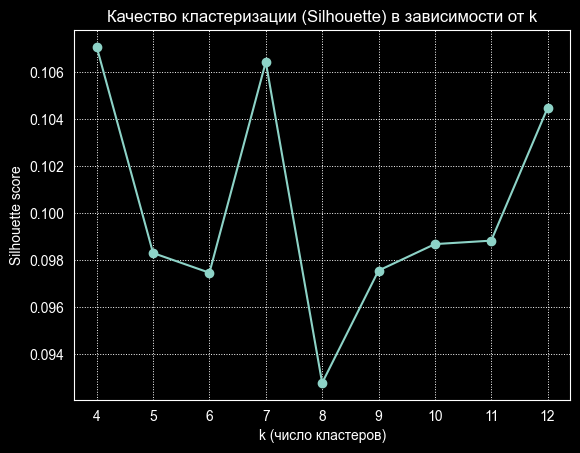

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(metrics_k["k"], metrics_k["silhouette"], marker="o")
plt.xlabel("k (число кластеров)")
plt.ylabel("Silhouette score")
plt.title("Качество кластеризации (Silhouette) в зависимости от k")
plt.xticks(metrics_k["k"])
plt.grid(True, linestyle=":", linewidth=0.7)
plt.show()

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
df["segment_id"] = kmeans.fit_predict(X_scaled)

df.head()

,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__Film-Noir,genre_like__Horror,genre_like__Musical,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western,segment_id
0,1,53,53,4.188679,0.680967,3,5,0.849057,0.000000,0.043103,...,0.00000,0.000000,0.123203,0.000000,0.045175,0.026694,0.022587,0.020534,0.000000,3
1,2,125,125,3.712000,1.014539,1,5,0.560000,0.104000,0.192171,...,0.00388,0.005820,0.000000,0.009699,0.086324,0.059166,0.101843,0.054316,0.012609,1
2,3,49,49,3.938776,0.899263,2,5,0.734694,0.081633,0.186441,...,0.00000,0.014831,0.008475,0.006356,0.040254,0.048729,0.040254,0.016949,0.059322,0
3,4,21,21,4.190476,1.077917,1,5,0.857143,0.095238,0.327586,...,0.00000,0.056277,0.000000,0.000000,0.034632,0.138528,0.060606,0.043290,0.038961,0
4,5,181,181,3.143646,1.155338,1,5,0.414365,0.287293,0.090909,...,0.00804,0.027136,0.010050,0.022111,0.086432,0.039196,0.099497,0.021106,0.004020,1


In [15]:
seg_share_k4 = df['segment_id'].value_counts(normalize=True).sort_index()
seg_share_k4

segment_id
0    0.247185
1    0.314404
2    0.364073
3    0.074338
Name: proportion, dtype: float64

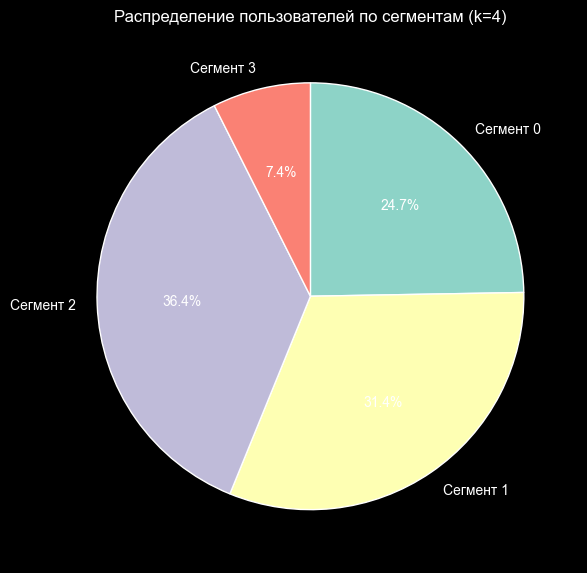

In [16]:
plt.figure(figsize=(6, 6))
plt.pie(
    seg_share_k4,
    labels=[f"Сегмент {i}" for i in seg_share_k4.index],
    autopct="%.1f%%",
    startangle=90,
    counterclock=False
)

plt.title("Распределение пользователей по сегментам (k=4)")
plt.tight_layout()
plt.show()

In [17]:
df = df.merge(users, on="user_id", how="left")
df

,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western,segment_id,gender,occupation,age_group_id
0,1,53,53,4.188679,0.680967,3,5,0.849057,0.000000,0.043103,...,0.000000,0.045175,0.026694,0.022587,0.020534,0.000000,3,F,11,1
1,2,125,125,3.712000,1.014539,1,5,0.560000,0.104000,0.192171,...,0.009699,0.086324,0.059166,0.101843,0.054316,0.012609,1,M,17,7
2,3,49,49,3.938776,0.899263,2,5,0.734694,0.081633,0.186441,...,0.006356,0.040254,0.048729,0.040254,0.016949,0.059322,0,M,16,3
3,4,21,21,4.190476,1.077917,1,5,0.857143,0.095238,0.327586,...,0.000000,0.034632,0.138528,0.060606,0.043290,0.038961,0,M,8,5
4,5,181,181,3.143646,1.155338,1,5,0.414365,0.287293,0.090909,...,0.022111,0.086432,0.039196,0.099497,0.021106,0.004020,1,M,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,6036,827,827,3.292624,1.025808,1,5,0.443773,0.206771,0.094244,...,0.021925,0.077222,0.085371,0.084206,0.027745,0.009895,1,F,16,3
6036,6037,193,193,3.730570,0.883853,1,5,0.606218,0.067358,0.071611,...,0.030508,0.054915,0.088136,0.166102,0.037966,0.010169,1,F,2,5
6037,6038,16,16,3.812500,0.910586,2,5,0.625000,0.062500,0.058824,...,0.000000,0.155039,0.031008,0.000000,0.124031,0.000000,2,F,2,7
6038,6039,117,117,3.846154,0.726534,2,5,0.717949,0.034188,0.029851,...,0.068999,0.110787,0.029155,0.056365,0.032070,0.008746,3,F,1,5


In [18]:
from sklearn.metrics import pairwise_distances

centroids = kmeans.cluster_centers_
representatives = {}

for seg in sorted(df['segment_id'].unique()):
    idx = df.index[df['segment_id'] == seg]
    X_seg = X_scaled[idx]
    dists = pairwise_distances(X_seg, centroids[seg].reshape(1, -1))
    rep_idx = idx[np.argmin(dists)]
    representatives[seg] = rep_idx

representatives

{np.int32(0): np.int64(4620),
 np.int32(1): np.int64(32),
 np.int32(2): np.int64(2205),
 np.int32(3): np.int64(2034)}

In [19]:
centroid_profiles = df.loc[list(representatives.values())]
centroid_profiles

,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western,segment_id,gender,occupation,age_group_id
4620,4621,183,183,3.469945,1.036649,1,5,0.513661,0.185792,0.178571,...,0.010204,0.061862,0.139668,0.098214,0.041454,0.010842,0,M,5,3
32,33,366,366,3.505464,1.016964,1,5,0.510929,0.169399,0.096821,...,0.025041,0.055008,0.066092,0.128900,0.032020,0.013547,1,M,4,5
2205,2206,149,149,3.738255,1.048783,1,5,0.624161,0.107383,0.099315,...,0.025210,0.107376,0.037348,0.084034,0.045752,0.007470,2,M,8,5
2034,2035,161,161,3.559006,0.967243,1,5,0.552795,0.149068,0.092391,...,0.003802,0.049430,0.073004,0.047909,0.015970,0.013688,3,F,1,2


In [20]:
kmeans7 = KMeans(n_clusters=7, random_state=42, n_init="auto")
df["segment_id"] = kmeans7.fit_predict(X_scaled)

df.head()

,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western,segment_id,gender,occupation,age_group_id
0,1,53,53,4.188679,0.680967,3,5,0.849057,0.000000,0.043103,...,0.000000,0.045175,0.026694,0.022587,0.020534,0.000000,3,F,11,1
1,2,125,125,3.712000,1.014539,1,5,0.560000,0.104000,0.192171,...,0.009699,0.086324,0.059166,0.101843,0.054316,0.012609,6,M,17,7
2,3,49,49,3.938776,0.899263,2,5,0.734694,0.081633,0.186441,...,0.006356,0.040254,0.048729,0.040254,0.016949,0.059322,0,M,16,3
3,4,21,21,4.190476,1.077917,1,5,0.857143,0.095238,0.327586,...,0.000000,0.034632,0.138528,0.060606,0.043290,0.038961,0,M,8,5
4,5,181,181,3.143646,1.155338,1,5,0.414365,0.287293,0.090909,...,0.022111,0.086432,0.039196,0.099497,0.021106,0.004020,1,M,21,3


In [21]:
seg_share_k7 = df['segment_id'].value_counts(normalize=True).sort_index()
seg_share_k7

segment_id
0    0.229139
1    0.260430
2    0.148675
3    0.057947
4    0.041556
5    0.004470
6    0.257781
Name: proportion, dtype: float64

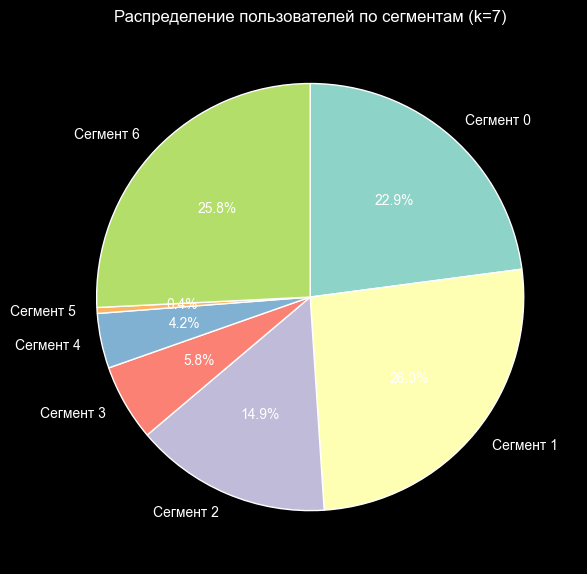

In [22]:
plt.figure(figsize=(6, 6))
plt.pie(
    seg_share_k7,
    labels=[f"Сегмент {i}" for i in seg_share_k7.index],
    autopct="%.1f%%",
    startangle=90,
    counterclock=False
)

plt.title("Распределение пользователей по сегментам (k=7)")
plt.tight_layout()
plt.show()

In [23]:
kmeans12 = KMeans(n_clusters=12, random_state=42, n_init="auto")
df["segment_id"] = kmeans12.fit_predict(X_scaled)

df.head()

,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western,segment_id,gender,occupation,age_group_id
0,1,53,53,4.188679,0.680967,3,5,0.849057,0.000000,0.043103,...,0.000000,0.045175,0.026694,0.022587,0.020534,0.000000,11,F,11,1
1,2,125,125,3.712000,1.014539,1,5,0.560000,0.104000,0.192171,...,0.009699,0.086324,0.059166,0.101843,0.054316,0.012609,5,M,17,7
2,3,49,49,3.938776,0.899263,2,5,0.734694,0.081633,0.186441,...,0.006356,0.040254,0.048729,0.040254,0.016949,0.059322,5,M,16,3
3,4,21,21,4.190476,1.077917,1,5,0.857143,0.095238,0.327586,...,0.000000,0.034632,0.138528,0.060606,0.043290,0.038961,5,M,8,5
4,5,181,181,3.143646,1.155338,1,5,0.414365,0.287293,0.090909,...,0.022111,0.086432,0.039196,0.099497,0.021106,0.004020,0,M,21,3


In [24]:
seg_share_k12 = df['segment_id'].value_counts(normalize=True).sort_index()
seg_share_k12

segment_id
0     0.179801
1     0.044536
2     0.188245
3     0.112914
4     0.112252
5     0.138907
6     0.095033
7     0.078146
8     0.015066
9     0.009603
10    0.003311
11    0.022185
Name: proportion, dtype: float64

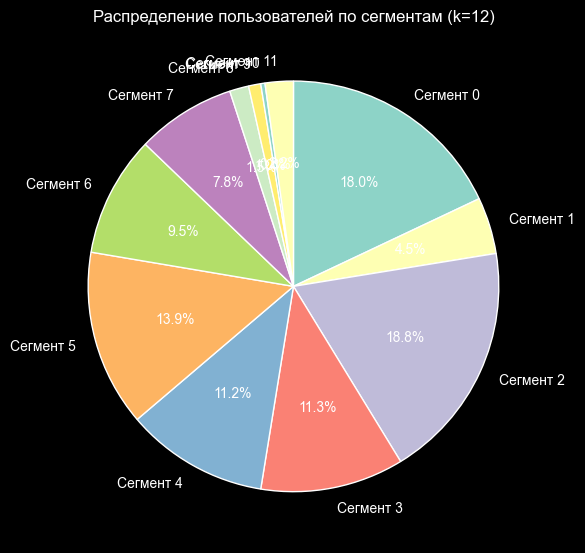

In [25]:
plt.figure(figsize=(6, 6))
plt.pie(
    seg_share_k12,
    labels=[f"Сегмент {i}" for i in seg_share_k12.index],
    autopct="%.1f%%",
    startangle=90,
    counterclock=False
)

plt.title("Распределение пользователей по сегментам (k=12)")
plt.tight_layout()
plt.show()

In [26]:
seg_sizes = pd.Series(df["segment_id"]).value_counts().sort_index()
seg_sizes_k12 = seg_share_k12.rename_axis("segment_id").reset_index(name="size")
seg_sizes_k12["share"] = seg_sizes_k12["size"] / seg_sizes_k12["size"].sum()
seg_sizes_k12.sort_values("size")

,segment_id,size,share
10,10,0.003311,0.003311
9,9,0.009603,0.009603
8,8,0.015066,0.015066
11,11,0.022185,0.022185
1,1,0.044536,0.044536
7,7,0.078146,0.078146
6,6,0.095033,0.095033
4,4,0.112252,0.112252
3,3,0.112914,0.112914
5,5,0.138907,0.138907


In [27]:
MIN_SHARE = 0.03
MIN_SIZE = int(len(df) * MIN_SHARE)

valid_segments_k12 = seg_sizes[seg_sizes >= MIN_SIZE].index.tolist()
valid_segments_k12

[0, 1, 2, 3, 4, 5, 6, 7]

In [28]:
from sklearn.metrics import pairwise_distances
import numpy as np

centroids_k12 = kmeans12.cluster_centers_
representatives_k12 = {}

for seg in valid_segments_k12:
    idx = df.index[df["segment_id"] == seg]
    X_seg = X_scaled[idx]
    dists = pairwise_distances(
        X_seg,
        centroids_k12[seg].reshape(1, -1)
    )
    rep_idx = idx[np.argmin(dists)]
    representatives_k12[seg] = rep_idx

representatives_k12

{0: np.int64(3383),
 1: np.int64(2554),
 2: np.int64(3276),
 3: np.int64(5599),
 4: np.int64(5064),
 5: np.int64(5033),
 6: np.int64(168),
 7: np.int64(787)}

In [29]:
centroid_profiles_k12 = df.loc[list(representatives_k12.values())]
centroid_profiles_k12

,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western,segment_id,gender,occupation,age_group_id
3383,3384,123,123,3.560976,1.033428,1,5,0.536585,0.154472,0.106719,...,0.030939,0.065193,0.079558,0.091713,0.041989,0.007735,0,M,8,4
2554,2555,151,151,3.576159,0.934074,1,5,0.569536,0.112583,0.091463,...,0.075278,0.046193,0.060736,0.123182,0.042772,0.011976,1,M,8,7
3276,3277,141,141,4.049645,1.002328,1,5,0.751773,0.092199,0.071942,...,0.018936,0.077547,0.028855,0.070334,0.047791,0.007214,2,M,18,3
5599,5600,261,261,3.904215,1.120792,1,5,0.701149,0.114943,0.044990,...,0.008205,0.139487,0.035385,0.033846,0.023590,0.006667,3,F,1,5
5064,5065,253,253,3.664032,1.062422,1,5,0.608696,0.150198,0.100159,...,0.029092,0.071646,0.078593,0.075988,0.041685,0.019540,4,M,15,3
5033,5034,132,132,3.931818,0.830646,2,5,0.696970,0.037879,0.213415,...,0.012608,0.059102,0.115051,0.131600,0.044917,0.000000,5,F,16,3
168,169,522,522,3.557471,1.001703,1,5,0.605364,0.160920,0.133721,...,0.014602,0.061925,0.059221,0.082747,0.034884,0.012710,6,M,8,3
787,788,186,186,3.532258,0.936660,1,5,0.537634,0.134409,0.154334,...,0.010850,0.067511,0.167571,0.054250,0.019892,0.005425,7,M,1,3


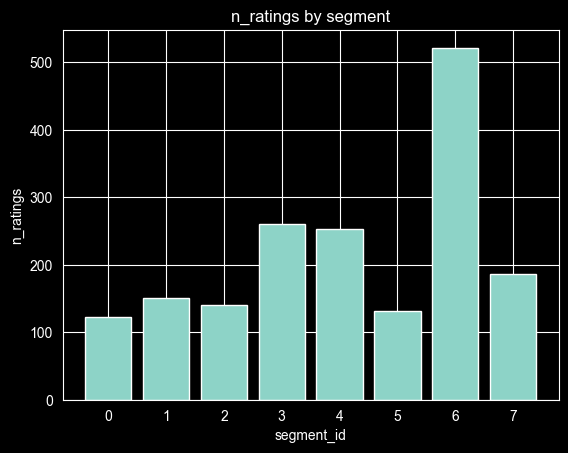

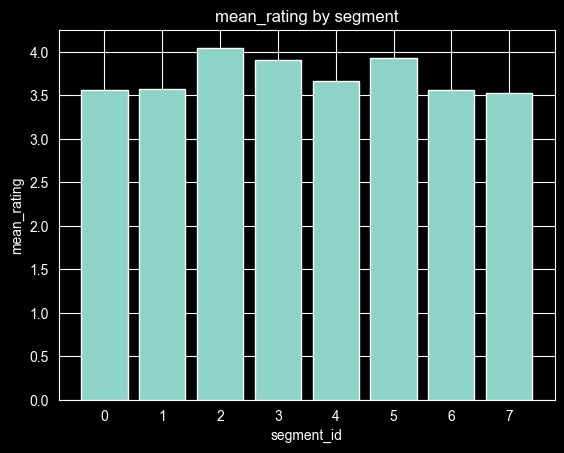

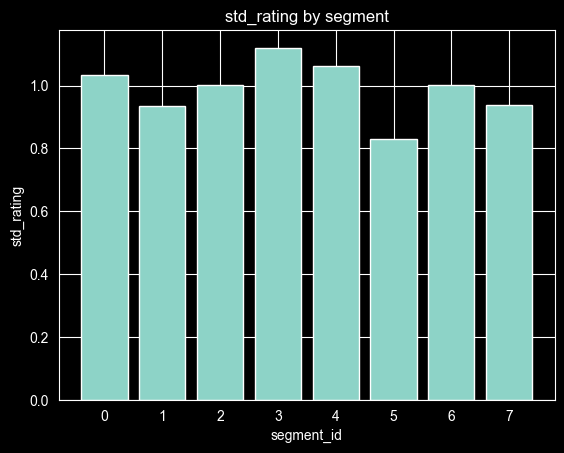

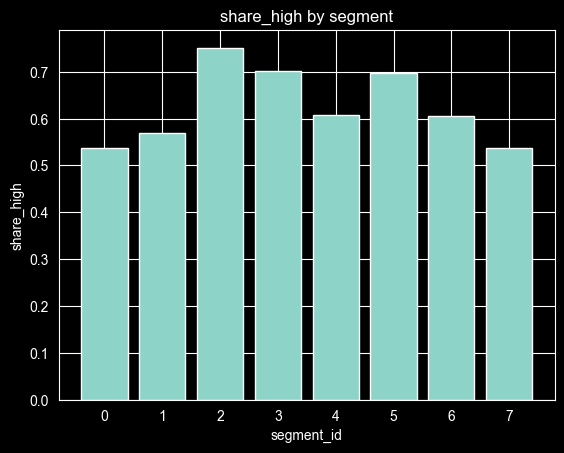

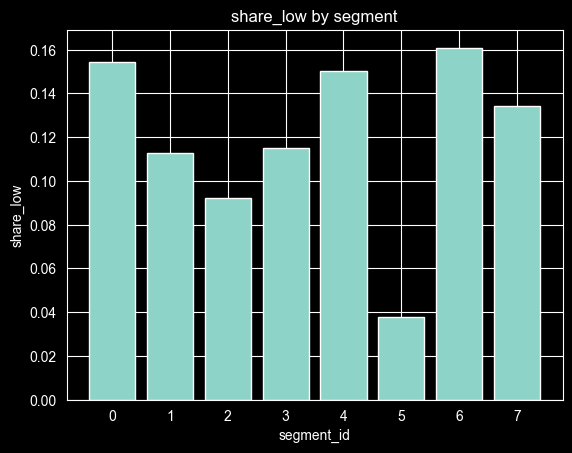

In [40]:
key_metrics = [
    "n_ratings", "mean_rating", "std_rating",
    "share_high", "share_low"
]

centroid_profiles_k12[key_metrics].round(3)

for m in key_metrics:
    plt.figure()
    plt.bar(centroid_profiles_k12["segment_id"], centroid_profiles_k12[m])
    plt.title(f"{m} by segment")
    plt.xlabel("segment_id")
    plt.ylabel(m)
    plt.show()

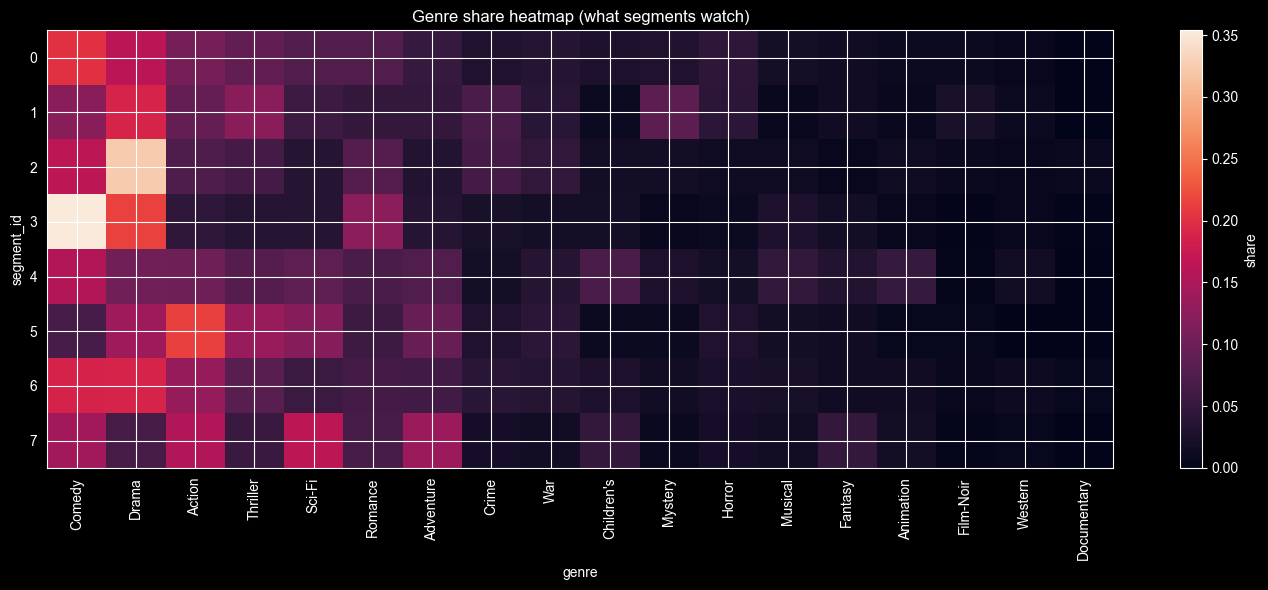

In [31]:
genre_share_cols = [c for c in centroid_profiles_k12.columns if c.startswith("genre_share__")]

genre_order = centroid_profiles_k12[genre_share_cols].mean().sort_values(ascending=False).index.tolist()

M = centroid_profiles_k12[genre_order].to_numpy()

plt.figure(figsize=(14, 6))
plt.imshow(M, aspect="auto")
plt.title("Genre share heatmap (what segments watch)")
plt.xlabel("genre")
plt.ylabel("segment_id")

plt.xticks(
    ticks=np.arange(len(genre_order)),
    labels=[g.replace("genre_share__", "") for g in genre_order],
    rotation=90
)
plt.yticks(
    ticks=np.arange(len(centroid_profiles_k12.index)),
    labels=centroid_profiles_k12["segment_id"]
)

plt.colorbar(label="share")
plt.tight_layout()
plt.show()


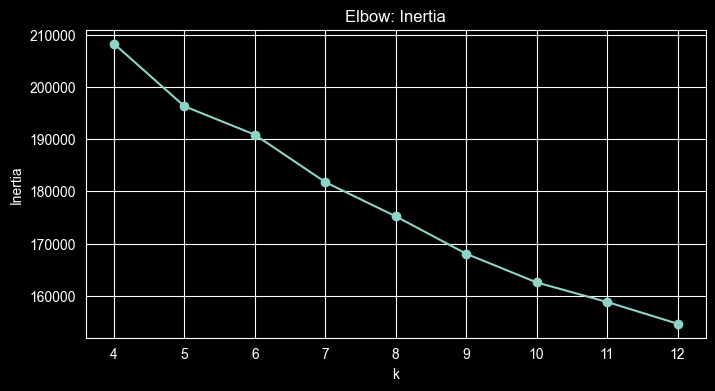

In [32]:
plt.figure(figsize=(8,4))
plt.plot(list(k_values), inertias, marker="o")
plt.title("Elbow: Inertia")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [33]:
kmeans5 = KMeans(n_clusters=5, random_state=42, n_init="auto")
df["segment_id"] = kmeans5.fit_predict(X_scaled)

df.head()

,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western,segment_id,gender,occupation,age_group_id
0,1,53,53,4.188679,0.680967,3,5,0.849057,0.000000,0.043103,...,0.000000,0.045175,0.026694,0.022587,0.020534,0.000000,3,F,11,1
1,2,125,125,3.712000,1.014539,1,5,0.560000,0.104000,0.192171,...,0.009699,0.086324,0.059166,0.101843,0.054316,0.012609,0,M,17,7
2,3,49,49,3.938776,0.899263,2,5,0.734694,0.081633,0.186441,...,0.006356,0.040254,0.048729,0.040254,0.016949,0.059322,0,M,16,3
3,4,21,21,4.190476,1.077917,1,5,0.857143,0.095238,0.327586,...,0.000000,0.034632,0.138528,0.060606,0.043290,0.038961,0,M,8,5
4,5,181,181,3.143646,1.155338,1,5,0.414365,0.287293,0.090909,...,0.022111,0.086432,0.039196,0.099497,0.021106,0.004020,1,M,21,3


In [34]:
seg_share_k5 = df['segment_id'].value_counts(normalize=True).sort_index()
seg_share_k5

segment_id
0    0.242881
1    0.259106
2    0.304305
3    0.064073
4    0.129636
Name: proportion, dtype: float64

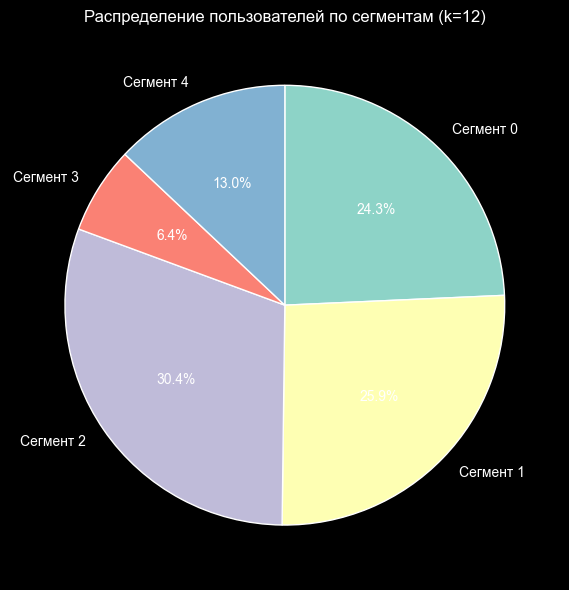

In [35]:
plt.figure(figsize=(6, 6))
plt.pie(
    seg_share_k5,
    labels=[f"Сегмент {i}" for i in seg_share_k5.index],
    autopct="%.1f%%",
    startangle=90,
    counterclock=False
)

plt.title("Распределение пользователей по сегментам (k=12)")
plt.tight_layout()
plt.show()

In [36]:
centroids = kmeans5.cluster_centers_
representatives = {}

for seg in sorted(df['segment_id'].unique()):
    idx = df.index[df['segment_id'] == seg]
    X_seg = X_scaled[idx]
    dists = pairwise_distances(X_seg, centroids[seg].reshape(1, -1))
    rep_idx = idx[np.argmin(dists)]
    representatives[seg] = rep_idx

representatives

{np.int32(0): np.int64(4620),
 np.int32(1): np.int64(3453),
 np.int32(2): np.int64(2205),
 np.int32(3): np.int64(2034),
 np.int32(4): np.int64(4597)}

In [37]:
centroid_profiles = df.loc[list(representatives.values())]
centroid_profiles

,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__Mystery,genre_like__Romance,genre_like__Sci-Fi,genre_like__Thriller,genre_like__War,genre_like__Western,segment_id,gender,occupation,age_group_id
4620,4621,183,183,3.469945,1.036649,1,5,0.513661,0.185792,0.178571,...,0.010204,0.061862,0.139668,0.098214,0.041454,0.010842,0,M,5,3
3453,3454,345,345,3.530435,1.022893,1,5,0.495652,0.159420,0.140669,...,0.014274,0.080492,0.057891,0.104282,0.026566,0.008327,1,M,1,2
2205,2206,149,149,3.738255,1.048783,1,5,0.624161,0.107383,0.099315,...,0.025210,0.107376,0.037348,0.084034,0.045752,0.007470,2,M,8,5
2034,2035,161,161,3.559006,0.967243,1,5,0.552795,0.149068,0.092391,...,0.003802,0.049430,0.073004,0.047909,0.015970,0.013688,3,F,1,2
4597,4598,105,105,3.780952,0.940345,1,5,0.628571,0.085714,0.095960,...,0.048128,0.054813,0.040107,0.109626,0.045455,0.009358,4,F,4,4


In [38]:
age_groups = pd.read_csv("../age_groups.csv")
occupations = pd.read_csv("../occupations.csv")

In [39]:
centroid_profiles = (centroid_profiles.merge(age_groups, how="left", left_on="age_group_id", right_on="group_id")
                     .merge(occupations, how="left", left_on="occupation", right_on="occ_id"))
centroid_profiles.head()

,user_id,n_ratings,n_movies,mean_rating,std_rating,min_rating,max_rating,share_high,share_low,genre_share__Action,...,genre_like__War,genre_like__Western,segment_id,gender,occupation,age_group_id,group_id,group_label,occ_id,occ_name
0,4621,183,183,3.469945,1.036649,1,5,0.513661,0.185792,0.178571,...,0.041454,0.010842,0,M,5,3,3,25_34,5,College/Grad student
1,3454,345,345,3.530435,1.022893,1,5,0.495652,0.159420,0.140669,...,0.026566,0.008327,1,M,1,2,2,18_24,1,Other
2,2206,149,149,3.738255,1.048783,1,5,0.624161,0.107383,0.099315,...,0.045752,0.007470,2,M,8,5,5,45_49,8,Executive/Managerial
3,2035,161,161,3.559006,0.967243,1,5,0.552795,0.149068,0.092391,...,0.015970,0.013688,3,F,1,2,2,18_24,1,Other
4,4598,105,105,3.780952,0.940345,1,5,0.628571,0.085714,0.095960,...,0.045455,0.009358,4,F,4,4,4,35_44,4,Clerical/Admin


### Segment 1: Молодые активные экшен- и sci-fi-ориентированные студенты

**Активность и оценки**
- Средняя активность: ~183 оценок.
- Средняя оценка ~3.47 при заметном разбросе (std ~1.04): ставит и низкие, и высокие.
- share_high ~0.51, share_low ~0.19: половина хороших, но плохие тоже не стесняется ставить.

**Вкус**
- Ядро по просмотрам: Action (0.18), Sci-Fi (0.15), Drama (0.13), Adventure (0.10), Thriller (0.096).
- По “любви” чуть выделяются Drama (like > share) и War (like > share): драму и военные ценит немного сильнее.

**Демография:**
Типичный представитель сегмента — мужчина 25–34 лет, студент или аспирант. Для данной возрастной и профессиональной группы характерно активное потребление динамичного, зрелищного контента, часто сочетающегося с элементами социальной или моральной проблематики (драма, война). Это объясняет сочетание экшена и фантастики с интересом к более серьёзным сюжетам

### Segment 2: Молодые высокоактивные пользователи со сбалансированным вкусом

**Активность и оценки**
- Высокий уровень активности (в среднем более 340 оценок).
- Средняя оценка составляет около 3.53 при умеренном разбросе значений

**Вкус**
- Жанровая структура сегмента характеризуется сбалансированным сочетанием Drama, Comedy, Action и Thriller.
- Соотношение долей просмотров и взвешенных предпочтений практически совпадает, что говорит о консистентности вкуса.

**Демография:**
Сегмент представлен мужчинами 18–24 лет, без чётко выраженной профессиональной принадлежности. Для этой возрастной группы характерны экспериментирование с контентом и высокая активность, что отражается в жанровом разнообразии и высокой интенсивности просмотров.

### Segment 3: Зрелые позитивные зрители, ориентированные на драму и комедию

**Активность и оценки**
- Сегмент характеризуется умеренной активностью (около 150 оценок)
- Самым позитивным стилем оценивания среди всех сегментов. Средняя оценка превышает 3.7, а доля отрицательных оценок минимальна.

**Вкус**
- Основными жанрами являются Drama и Comedy, при этом драматические фильмы обладают наибольшей значимостью.

**Демография:**
Типичный пользователь сегмента — мужчина 45–49 лет, занимающий управленческую должность. Для данной возрастной и профессиональной группы характерно предпочтение сюжетно насыщенного, эмоционально и социально значимого контента, а также более терпимое и позитивное отношение к выбранным фильмам.

### Segment 4: Молодой семейно‑ориентированный комедийный сегмент

**Активность и оценки**
- Пользователи сегмента демонстрируют средний уровень активности и наиболее стабильный стиль оценивания.

**Вкус**
- Жанровый профиль ориентирован на Comedy, Children’s, Animation и Musical.

**Демография:**
Сегмент представлен девушки 18–24 лет. Для данной группы характерно потребление лёгкого, эмоционально комфортного контента, ориентированного на совместный или фоновый просмотр.

### Segment 5: Зрелые позитивные любители детективно‑драматического контента

**Активность и оценки**
- Это наименее активный сегмент, однако пользователи демонстрируют высокую среднюю оценку
- Минимальную долю негативных отзывов.

**Вкус**
- Доминирует Drama, дополненная Thriller, Crime, Mystery и Film‑Noir.

**Демография:**
Типичный представитель — женщина 35–44 лет, работающая в административной сфере. Для данной группы характерно предпочтение интеллектуального, сюжетно сложного контента с элементами расследования и психологического напряжения.